# TempEst-NEXT Validation Suite

Daniel Philippus

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of 331 (nominal 400) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).  Test-set validations have been run during the development process, but are never used to directly inform model design.

The test suite also illustrates model runtime.

Some cells were used for initial data preparation, but do not need to be rerun.  These have been set to "raw" rather than Python, so simply running the entire Notebook will run all tests but nothing extraneous.

## Dependencies

To run the entire Notebook, requirements are:

- Python dependencies: TempEst-NEXT, matplotlib, and seaborn.  TempEst-NEXT is available (under that name) on the Python Package Index, so `pip install TempEst-NEXT`.  This will also install, as a dependency, TempEst-NEWT, the calibrated version of the model.
- A directory (specify location in `bp=` in the first cell) containing `DevData.csv`, `TestData.csv`, `DevDataHRRR3.csv`, and `TestDataHRRR3.csv`.  These should be provided with the notebook.  It should also contain a `results` subdirectory.
- In the same directory as the notebook:
    - An `ecoregions` directory, containing `NA_CEC_Eco_Level1.shp` (EPA Level I Ecoregions).
    - A `usa_states` directory, containing `usa_states/cb_2018_us_state_20m.shp` (US Census state outlines shapefile).
    - A `val_figures` directory

The preprocessing chunks have additional requirements, but are only used to generate the above data files and so don't need to be run.  They are set to `raw`, not `code`, so if the entire notebook is run they will not be executed.

Running the Notebook will reproduce all manuscript performance data and figures, except those relating to "true" forecasting (as opposed to reforecasting).  This is because performance evaluation for "true" forecasting requires separate steps to be run days apart and therefore can't be fully automated in a single run, though simply generating the forecast is automatic.

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on historical runs for computational convenience.  It is assumed that any performance discrepancies in forecasting vs historical prediction would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model historical prediction and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged historical prediction and forecasting performance
3. Ungaged-region historical prediction performance
4. Ungaged-elevation historical prediction performance
5. Ungaged-time-period historical prediction performance

## Tests

The following tests are used to assess the above performance characteristics.  Forecast tests cover just 2022, since HRRR retrieval is slow.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the full dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast period of 2 days.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Historical run (met estimate) only.  This uses the development dataset to show whether model tuning introduced any performance discrepancies (compared to test set validation).
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for 2-day (tomorrow) forecasts.  This has to be done with HRRR, since GFS doesn't have as readily-available long-term archives.
    - Trained on estimates/test on forecasts (forecast with heterogeneous data).
    - Trained on forecasts (homogeneous).
- Extrapolation historical prediction tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All historical prediction.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
  - Weather: train models excluding wet/dry/hot sites and test them on the excluded set. This tests whether the model can extrapolate over climate conditions.
- True forecasting: run TempEst-NEXT with a 1-16 day lead time in real time (HRRR and GFS), then come back and check the performance.  This needs to be rerun many times, preferably over multiple seasons, to be meaningful.


A full run takes about 3 hours.

# Data Preparation

In [ ]:
import NEXT
from NEXT import wforecast
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import dataretrieval.nwis as nwis
import geopandas as gpd
import matplotlib.animation as anim
import shapely
import scipy
from sklearn.ensemble import RandomForestClassifier
from scores.probability import brier_score_for_ensemble
import xarray as xr
from math import floor, ceil
warnings.catch_warnings(action="ignore")
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

Use the `variant` options below to indicate the use of a different model implementation, so that all validations are rerun and results saved separately.  `coef_variant` refers to coefficient estimation and `newt_variant` to NEWT model design.

In [ ]:
metric = ""  # "" for mean, or use "min", "max". This allows coefficient pickles to be saved appropriately.
coef_variant = f"_reference{metric}"  # Current reference: constant dates, 5-PC
newt_variant = f"_reference{metric}"
rerun = True

There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [ ]:
datafiles = [bp + x + ".csv" for x in ["DevDataBuffers", "TestDataBuffers", "DevDataHRRR3", "TestDataHRRR3"]]

In [ ]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).drop(columns=["swe", "tmin"]).dropna()
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
test_data = pd.read_csv(bp + "TestDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).dropna()
test_data["day"] = test_data["date"].dt.day_of_year
all_data = pd.concat([dev_data, test_data]).drop(columns=["asp_north", "asp_east", "id_type", "unknown", "elev_std", "frozen", "cold_prcp"])
test_data_hrrr = pd.read_csv(bp + "TestDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(test_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
dev_data_hrrr = pd.read_csv(bp + "DevDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(dev_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
all_data_hrrr = pd.concat([test_data_hrrr, dev_data_hrrr]).drop(columns=["elev_std", "asp_north", "asp_east"])

## Min/Max Handling

In [5]:
def mergeit(data, newdat):
    return data.drop(columns=["temperature"]).merge(newdat, on=["id", "date"], how="left")
if metric == "max":
    maxpath = bp + "MaxTemp.csv"
    if not os.path.exists(maxpath):
        glist = all_data["id"].unique().tolist() # max 00001, min 00002
        maxt = nwis.get_dv(glist, "2000-01-01", "2023-12-31", parameterCd="00010", statCd="00001")[0].reset_index()[["site_no", "datetime", "00010_Maximum"]].rename(
                columns={"00010_Maximum": "temperature", "site_no": "id", "datetime": "date"}
            ).dropna().assign(date=lambda x: x["date"].dt.normalize().dt.tz_localize(None))
        maxt = maxt[maxt["temperature"] > -1]
        maxt.to_csv(maxpath, index=False)
    else:
        maxt = pd.read_csv(maxpath, dtype={"id": "str"}, parse_dates=["date"])
    dev_data = mergeit(dev_data, maxt).dropna()
    test_data = mergeit(test_data, maxt).dropna()
    all_data = mergeit(all_data, maxt).dropna()
    test_data_hrrr = mergeit(test_data_hrrr, maxt).dropna()
    dev_data_hrrr = mergeit(dev_data_hrrr, maxt).dropna()
    all_data_hrrr = mergeit(all_data_hrrr, maxt).dropna()
if metric == "min":
    minpath = bp + "MinTemp.csv"
    if not os.path.exists(minpath):
        glist = all_data["id"].unique().tolist() # max 00001, min 00002
        mint = nwis.get_dv(glist, "2000-01-01", "2023-12-31", parameterCd="00010", statCd="00002")[0].reset_index()[["site_no", "datetime", "00010_Minimum"]].rename(
                columns={"00010_Minimum": "temperature", "site_no": "id", "datetime": "date"}
            ).dropna().assign(date=lambda x: x["date"].dt.normalize().dt.tz_localize(None))
        mint = mint[mint["temperature"] > -1]
        mint.to_csv(minpath, index=False)
    else:
        mint = pd.read_csv(minpath, dtype={"id": "str"}, parse_dates=["date"])
    dev_data = mergeit(dev_data, mint).dropna()
    test_data = mergeit(test_data, mint).dropna()
    all_data = mergeit(all_data, mint).dropna()
    test_data_hrrr = mergeit(test_data_hrrr, mint).dropna()
    dev_data_hrrr = mergeit(dev_data_hrrr, mint).dropna()
    all_data_hrrr = mergeit(all_data_hrrr, mint).dropna()

## Forecast Archive Retrieval (does not need to be run)

A one-month run takes 0.02 hours, so 72 months should be about 1.5 hours, for a total of ~500 core-hours for the test set.  Needs to be run distributed.

## Data Preprocessing (does not need to be run)

# Calibrated Tests

Full dataset.

In [6]:
def cut_dev(gid, data, start=None):
    idd = data[data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, data, test_data = None, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid, data)
    if test_data is None:
        test_data = data
    # try:
    if cutoff is not None:
        test = cal_fn(gid, data, cutoff)
        model = NEWT.Watershed.from_data(train)
        print("|", end="")
        if model is not None:
            return model.run_series(test)
    # except Exception as e:
    #     warnings.warn(str(e))

## Historical Run

With full-series runs and GAM-sensitivity, ~1000 watersheds take about 10 minutes to train and predict, for ~0.5 seconds each. Similar runtime with libSCHEMA: 8.9 minutes for 1225 watersheds.

In [7]:
file = bp + f"results/calibrated_hindcast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data) for x in all_data["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, global performance is very similar to gagewise performance.

Using GAM-anomaly reduced median and global RMSE by about 0.1 C to 1.4 C (for both).  Anomaly NSE increased to 0.61 (0.92 globally), median R2 to 0.95, and global R2 to 0.97.  Overall NSE increased to 0.95 and 0.97.

In [8]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1225.000000  1225.000000  1225.000000    1225.000000     1225.000000   
mean      0.937312     1.398516     0.937287       0.976987        0.952473   
std       0.067873     0.418146     0.067976       0.017492        0.048964   
min       0.373389     0.105854     0.368812       0.816626        0.287647   
25%       0.933294     1.158044     0.933293       0.969716        0.937219   
50%       0.952759     1.385080     0.952758       0.980486        0.959158   
75%       0.967880     1.606672     0.967812       0.988845        0.978736   
max       0.992155     6.881183     0.992146       0.999010        1.000000   

        AnomalyNSE        Pbias         Bias      MaxMiss  
count  1089.000000  1225.000000  1225.000000  1225.000000  
mean      0.559311     0.018236     0.001662     1.232609  
std       0.198994     0.097704     0.007338     0.756956  
min      -0.345512    -0.231682    -0.025038    

In [9]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.967113,1.413639,0.967112,0.983519,0.604225,0.92177,0.011747,0.001567,1.457304


## Forecast

Trained and tested with HRRR.  Note this limits the data coverage (~2018-22).  Since the POR is shorter and there are fewer applicable watersheds, this takes 4 minutes.

Performance here is very similar, though a little worse; at calibrated sites, the seasonal skill dominates and the slight penalty to anomaly performance has little effect.  Median/global R2 0.95/0.96, RMSE 1.4/1.5 C, NSE 0.95/0.96, pbias 0.007%/0.01%, max-miss 1.3/1.1 C.

In [10]:
file = bp + f"results/calibrated_reforecast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data_hrrr) for x in all_data_hrrr["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [11]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1027.000000  1027.000000  1027.000000    1027.000000     1027.000000   
mean      0.935054     1.448859     0.935005       0.976924        0.977886   
std       0.049281     0.443155     0.049439       0.018148        0.020507   
min       0.475008     0.111067     0.474925       0.824091        0.781970   
25%       0.920185     1.122234     0.920181       0.969221        0.968671   
50%       0.945375     1.427085     0.945359       0.980629        0.981338   
75%       0.964453     1.802109     0.964441       0.989409        0.991856   
max       0.992155     2.779918     0.992146       0.999339        1.000000   

       AnomalyNSE        Pbias         Bias      MaxMiss  
count  866.000000  1027.000000  1027.000000  1027.000000  
mean     0.238313     0.026398     0.002339     1.366965  
std      9.301650     0.128278     0.009039     0.701687  
min   -273.105481    -0.231682    -0.025038     0.03

In [12]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.962069,1.510478,0.962065,0.978689,0.608743,0.916225,0.018175,0.002347,1.148731


# Test Set Validation

In [13]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 156 seconds to train


In [14]:
model.to_pickle(f"coefs{metric}.pickle")

## Historical Run

With single-pass and GAM-sensitivity, this takes 24 seconds, or about 0.01 seconds per year. Incremental predictions remain much slower, at about 15 seconds per site (2 seconds per year).

In [ ]:
def predict(ws, incremental=False):
    print("|", end="")
    # try:
    if incremental:
         return np.array(list(model.make_newt(ws, reset=True).get_newt().run_series_incremental(ws, "day")))
    return model.run(ws, reset=True)
    # except:
        # return None

In [ ]:
ppath = bp + f"results/TestSet_hindcast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 22 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,320.000000,320.000000,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.0,0.891524,2.296965,0.126920,0.977825,0.913657,0.411610,2.457129,0.187875,2.616059
std,4.643460,17.260681,0.0,0.138332,0.899283,7.513164,0.018832,0.076468,0.370406,11.802498,1.160447,1.764372
min,28.332787,-124.357089,0.0,0.051370,1.130900,-125.775955,0.824755,0.339466,-4.644218,-34.431418,-4.006223,0.285110
25%,36.555978,-111.425710,0.0,0.883815,1.802772,0.811624,0.971559,0.898901,0.305878,-3.540923,-0.488126,1.193816
50%,40.175895,-87.479876,0.0,0.936837,2.090879,0.898002,0.981334,0.931081,0.480857,0.993344,0.148782,2.316244
75%,43.327292,-81.167361,0.0,0.955984,2.529275,0.934736,0.989980,0.949809,0.603725,5.961305,0.842658,3.631724
max,48.984601,-67.935278,0.0,0.981450,7.779828,0.979169,0.999024,0.996135,0.757631,96.663221,5.738546,10.775794


In [ ]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.903224,2.447043,0.901252,0.986739,0.606809,0.764974,1.614137,0.213969,1.729979


### Predictability Analysis

Analyze spatiotemporal predictability in cross-validation.

#### Daily Spatial and Spatiotemporal

Predictability of DOY-mean for each DOY.

Predictability of daily/yearly timeseries for each DOY.

In [ ]:
doymean = preds.groupby(["id", "day"])[["temperature", "prediction"]].mean()

In [ ]:
r2s = doymean.groupby("day").apply(lambda x: x["temperature"].corr(x["prediction"])**2)

In [ ]:
r2s.describe()

count    365.000000
mean       0.820166
std        0.051353
min        0.684044
25%        0.784428
50%        0.824401
75%        0.855856
max        0.909085
dtype: float64

In [ ]:
r2st = preds.groupby("day").apply(lambda x: x["temperature"].corr(x["prediction"])**2, include_groups=False)

In [ ]:
r2st.describe()

count    365.000000
mean       0.772439
std        0.051939
min        0.635670
25%        0.740904
50%        0.775694
75%        0.809689
max        0.872888
dtype: float64

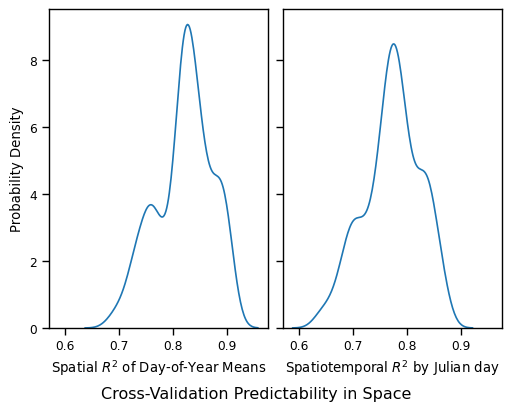

In [ ]:
(fig, [ax1, ax2]) = plt.subplots(1, 2, figsize=(5, 4), layout="compressed", sharex=True, sharey=True)
sns.kdeplot(r2s, ax=ax1)
sns.kdeplot(r2st, ax=ax2)
ax2.set_ylabel(None)
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Spatial $R^2$ of Day-of-Year Means")
ax2.set_xlabel("Spatiotemporal $R^2$ by Julian day")
fig.supxlabel("Cross-Validation Predictability in Space")
plt.savefig("val_figures/spatial_skill_kde.png", dpi=1200)

#### Seasonal Spatial

Predictability of each 3S coefficient.

We extract observed seasonality from the timeseries, but directly predict modeled seasonality, because variable time coverage means that timeseries-based modeled seasonality may be rather different from actual modeled seasonality. In particular, timeseries extraction tends to underestimate the seasonal anomalies, which resulted in much confusion.

In [ ]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = preds.assign(yrgrp = lambda x: x["date"].dt.year//5).groupby(["id", "yrgrp"]).apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False).droplevel(2)
ssn_mod = preds.groupby("id").apply(lambda x: get_ssn(x["day"], x["prediction"]), include_groups=False)

In [ ]:
ssn_obs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,0.0,592.000000
mean,12.933684,8.791062,326.027027,66.189189,150.292230,218.581081,0.847776,1.419237,NaN,1.055235
std,4.128589,2.752159,16.611698,33.074950,22.131833,17.044686,0.951192,0.895744,NaN,0.367471
min,3.393288,-0.283380,300.000000,1.000000,120.000000,200.000000,-0.667935,-1.626062,NaN,0.072100
25%,10.150057,6.930202,314.000000,32.000000,125.750000,200.000000,0.153374,0.810296,NaN,0.807994
50%,12.459845,9.171335,328.000000,80.000000,152.000000,216.000000,0.575735,1.422183,NaN,1.015276
75%,15.928265,10.939708,334.000000,90.000000,173.000000,238.000000,1.379352,2.010465,NaN,1.241790
max,24.748950,14.713100,365.000000,110.000000,180.000000,240.000000,5.232267,4.391050,NaN,2.695240


In [ ]:
test_data["yrgrp"] = test_data["date"].dt.year // 5
ssn_mod_dir = test_data.groupby("yrgrp").apply(lambda x: NEXT.coef_est.predict_all_coefficients(
    model.model,
    NEXT.coef_est.preprocess(x)), include_groups=False
).drop(columns=["at_coef", "elev"]).reset_index().set_index(["id", "yrgrp"])

In [ ]:
ssn_mod_dir.describe()

,level_1,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter
count,615.000000,615.000000,615.000000,6.150000e+02,615.000000,6.150000e+02,6.150000e+02,615.000000,615.000000
mean,153.253659,12.568740,8.668393,3.267546e+02,69.218085,1.540706e+02,2.177068e+02,0.804105,1.406103
std,88.845733,4.242211,2.178432,1.592911e-12,17.283735,1.052459e-12,1.649801e-12,0.756269,0.924975
min,0.000000,-3.847916,-0.906552,3.267546e+02,-7.540650,1.540706e+02,2.177068e+02,-0.607425,-3.462025
25%,76.500000,9.788997,7.207130,3.267546e+02,56.676952,1.540706e+02,2.177068e+02,0.257247,0.977950
50%,153.000000,12.292958,8.974995,3.267546e+02,74.417354,1.540706e+02,2.177068e+02,0.598279,1.302140
75%,230.000000,15.562888,10.228756,3.267546e+02,82.539301,1.540706e+02,2.177068e+02,1.288883,1.700433
max,308.000000,24.249481,13.225960,3.267546e+02,98.320594,1.540706e+02,2.177068e+02,3.971048,9.898400


How well does the space-for-time tradeoff work?

- Full timeseries: R2s 0.92, 0.63, 0.35, 0.49, 0.21
- By year:         R2s 0.88, 0.56, 0.21, 0.27, 0.16. Seasonal anomalies do much worse, annual variables are pretty similar.
- By two-year:     R2s 0.89, 0.56, 0.22, 0.35, 0.18. Recovered a lot of the performance.
- By five-year:    R2s 0.90, 0.60, 0.32, 0.42, 0.20. Very nearly recovered.

Space-for-time seems to work just fine, in other words. A model trained on space-only does nearly as well with a 5-year window and okay for shorter windows.

In [ ]:
fits = pd.Series({
    nm: ssn_obs[nm].corr(ssn_mod_dir[nm])**2  # hand-verified they are all positive
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
fits.round(2)

/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Intercept       0.90
Amplitude       0.60
FallDay          NaN
WinterDay       0.32
SpringDay        NaN
SummerDay        NaN
SpringSummer    0.42
FallWinter      0.20
dtype: float64

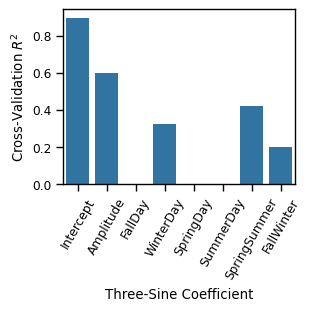

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="compressed")
sns.barplot(fits, ax=ax)
ax.set_xlabel("Three-Sine Coefficient")
ax.set_ylabel("Cross-Validation $R^2$")
plt.xticks(rotation=60)
plt.savefig("val_figures/skill_3s.png", dpi=1200)

In [ ]:
def nse(sim, obs):
    mse = np.mean((sim - obs)**2)
    ovar = obs.var()
    return 1 - mse/ovar
nses = pd.Series({
    nm: nse(ssn_mod_dir[nm], ssn_obs[nm])
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
nses

Intercept       0.896093
Amplitude       0.598259
FallDay        -0.000229
WinterDay       0.309631
SpringDay      -0.027456
SummerDay      -0.000942
SpringSummer    0.396347
FallWinter     -0.064655
dtype: float64

In [ ]:
# Add 1:1 plot
comb = ssn_mod_dir.iloc[:, :8].melt(ignore_index=False).rename(columns={"value": "mod"}).merge(
    ssn_obs.iloc[:, :8].melt(ignore_index=False).rename(columns={"value": "obs"}),
    on=["id", "variable"])

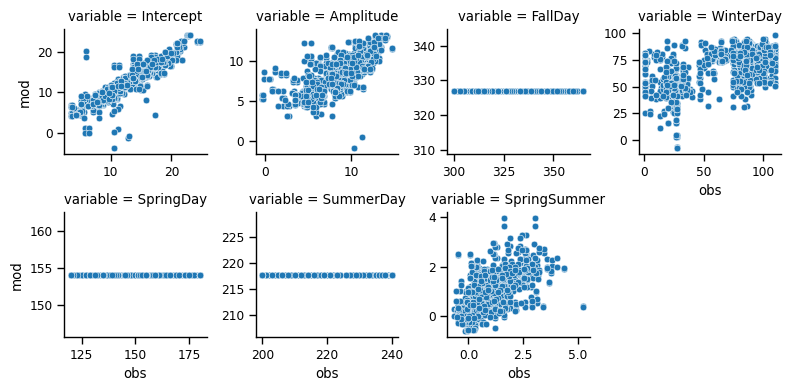

In [ ]:
sns.relplot(comb, x="obs", y="mod", col="variable", col_wrap=4, facet_kws={"sharex": False, "sharey": False},
           height=2)

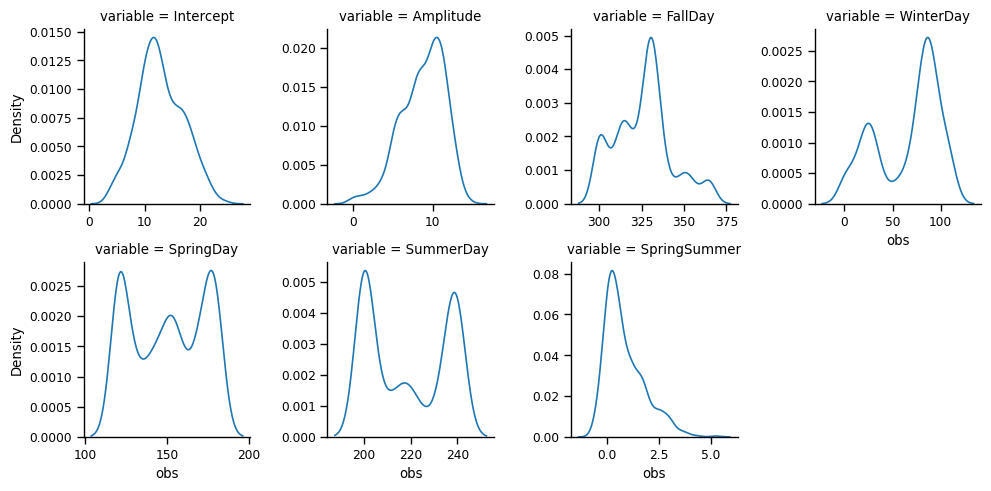

In [ ]:
sns.displot(comb, x="obs", col="variable", col_wrap=4, kind="kde", facet_kws={"sharex": False, "sharey": False}, height=2.5)

### Good/Bad Sites

This allows you to look at the best- and worst-performing test set sites on a map and cluster analysis and see if anything is going on. To make a map, uncomment the `to_file` line to generate a GeoJSON file. This can be directly imported to CalTopo, for instance.

In [ ]:
ranked = perf.sort_values("RMSE")
best = ranked.iloc[:100].assign(title = ["best" + str(ix) for ix in range(1,101)])
worst = ranked.iloc[-100:].assign(title = ["worst" + str(ix) for ix in range(100, 0, -1)])
midpt = int(len(ranked) / 2)
mid = ranked.iloc[(midpt-50):(midpt+50)].assign(title = ["middle" + str(ix) for ix in range(1, 101)])
comb = pd.concat([best, worst, mid])[["lat", "lon", "title"]]
comb["id"] = comb["title"]
pts = [shapely.Point(x.lon, x.lat) for x in comb.itertuples()]
comb = gpd.GeoDataFrame(data=comb, geometry=pts, crs=4326)
# comb.to_file("goodbadsites.json", driver='GeoJSON')

#### Quantifications

In [ ]:
best.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,39.964409,-93.383671,0.0,0.932844,1.627396,0.910653,0.977997,0.925262,0.489394,0.703534,0.078153,1.580246
std,4.768420,17.260258,0.0,0.042661,0.186205,0.068941,0.016812,0.036778,0.170985,4.185975,0.524271,0.880751
min,28.332787,-124.058144,0.0,0.733242,1.130900,0.548156,0.896933,0.810708,0.010164,-9.512223,-0.941440,0.335006
25%,36.289667,-108.778213,0.0,0.917968,1.513077,0.880926,0.970665,0.897924,0.353348,-2.364859,-0.273683,0.904169
50%,40.651848,-85.157792,0.0,0.946989,1.666976,0.936154,0.979914,0.933213,0.497085,0.668000,0.064768,1.405064
75%,43.343161,-80.633212,0.0,0.962343,1.791581,0.955122,0.989980,0.950677,0.639162,3.422432,0.466688,2.211434
max,48.616883,-71.791183,0.0,0.981450,1.863686,0.979169,0.997721,0.996135,0.757631,11.834878,1.464932,3.993613


In [ ]:
worst.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,39.952527,-99.905649,0.0,0.814726,3.182524,-1.543816,0.979337,0.892764,0.246530,4.236599,0.241143,3.892737
std,4.881614,17.500268,0.0,0.217621,1.122530,13.332751,0.023137,0.122960,0.573573,18.872664,1.774632,2.095435
min,29.952733,-124.357089,0.0,0.051370,2.401641,-125.775955,0.824755,0.339466,-4.644218,-34.431418,-4.006223,0.653300
25%,35.945447,-119.541493,0.0,0.837256,2.554711,0.506762,0.976186,0.907499,0.076662,-6.637362,-0.921047,2.213844
50%,39.447359,-98.162155,0.0,0.910536,2.754755,0.803515,0.984314,0.928601,0.344473,1.912681,0.248557,3.684216
75%,43.989914,-84.256375,0.0,0.939427,3.309996,0.876435,0.991834,0.951951,0.533955,11.951053,1.325921,5.421960
max,48.984601,-67.935278,0.0,0.979999,7.779828,0.935730,0.999024,0.995276,0.748873,96.663221,5.738546,10.775794


#### Classification Analysis

We'll use scikit-learn's Random Forest ensemble, since that's both simple and flexible.  70/30 train/test.

In [ ]:
allbw = pd.DataFrame({"id": pd.concat([best["id"], mid["id"], worst["id"]]), "rank": ["best"] * 100 + ["mid"] * 100 + ["worst"] * 100}
                    ).merge(NEXT.coef_est.preprocess(test_data), on="id"
                           ).drop(columns=["level_1_x", "level_1_y", "date", "day"])
train = allbw.groupby("rank").sample(n=70)
test = allbw.loc[-allbw["id"].isin(train["id"]),:]
getX = lambda x: x.drop(columns=["id", "rank"])
getY = lambda x: x["rank"]
# test = test.loc[test["rank"] != "mid",:]
# train = train.loc[train["rank"] != "mid", :]

In [ ]:
rf = RandomForestClassifier().fit(getX(train), getY(train))
rf.score(getX(train), getY(train))

1.0

In [ ]:
rf.score(getX(test), getY(test))

0.4777777777777778

Proportion correctly classified by chance should be 1/3, so accuracy needs to be much better than that to show meaningful predictability.

## Reforecast (heterogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

In [ ]:
def predict(ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except:
        return None

In [ ]:
ppath = bp + f"results/TestSet_reforecast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 19 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.876713,2.737655,-0.575910,0.978200,0.929851,0.280790,6.171368,0.720561,2.559338
std,4.677083,17.366814,0.0,0.145319,1.147493,15.169714,0.020264,0.071533,0.676082,15.558468,1.684465,1.912127
min,28.332787,-124.357089,0.0,0.011324,1.250854,-257.480884,0.824468,0.335259,-10.206550,-58.501135,-5.691062,0.198171
25%,36.610189,-111.746329,0.0,0.869032,2.074756,0.720695,0.972174,0.920568,0.223204,-1.305720,-0.187050,1.134176
50%,40.036652,-88.156111,0.0,0.921177,2.490388,0.835500,0.981762,0.945719,0.358912,5.442094,0.700090,2.034523
75%,43.349958,-81.273662,0.0,0.945139,3.116432,0.914244,0.991346,0.961223,0.490106,12.689742,1.687513,3.435129
max,48.984601,-67.935278,0.0,0.981119,12.922318,0.971045,0.999202,1.000000,0.732605,85.940811,9.779148,11.216863


## Reforecast (homogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

In [ ]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data_hrrr.dropna())
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 91 seconds to train


In [ ]:
model.to_pickle(f"coefs_hrrr{metric}.pickle")

In [ ]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [ ]:
ppath = bp + f"results/TestSet_reforecast_homog{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 20 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.878851,2.506369,-0.047371,0.978200,0.929851,0.313496,2.259318,0.158125,3.015930
std,4.677083,17.366814,0.0,0.145995,1.041795,8.922781,0.020264,0.071533,0.206345,13.142239,1.399689,1.975385
min,28.332787,-124.357089,0.0,0.032993,1.143851,-148.686521,0.824468,0.335259,-1.220646,-44.684790,-5.364909,0.196842
25%,36.610189,-111.746329,0.0,0.875318,1.940622,0.786281,0.972174,0.920568,0.233842,-4.356109,-0.584705,1.347103
50%,40.036652,-88.156111,0.0,0.922073,2.292379,0.871777,0.981762,0.945719,0.346342,1.972937,0.245622,2.703372
75%,43.349958,-81.273662,0.0,0.947225,2.726617,0.918790,0.991346,0.961223,0.442795,6.654710,0.899683,4.115438
max,48.984601,-67.935278,0.0,0.981333,12.454480,0.970881,0.999202,1.000000,0.669493,85.424581,8.617899,9.690449


## Uncertainty

In [ ]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 156 seconds to train


In [56]:
def predict(ws, Nco=30, Nanom=7):
    print("|", end="")
    # try:
    out = None
    for i in range(Nco):
        res = model.run(ws, draw=True, reset=True, quantiles=Nanom)
        minires = res.loc[:, res.columns.str.startswith("prediction_")]
        minires.columns = [x + f"_{i}" for x in minires.columns]
        if out is None:
            out = res[["date", "temperature"]]
        out = pd.concat([out, minires], axis=1)
    return out
    # except Exception as e:
    #     print(e)
    #     return None

In [57]:
ppath = bp + f"results/TestSet_hindcast_uncertainty{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False
                                             ).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)
values = pd.concat([preds[["id", "date", "temperature"]], preds.loc[:, preds.columns.str.startswith("prediction_")]], axis=1)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 914 seconds to predict


In [60]:
def brier(site_preds):
    array = xr.DataArray(
        site_preds.loc[:, site_preds.columns.str.startswith("prediction_")],
        dims=["x", "ensemble"],
        coords={"ensemble": range(len(site_preds.columns)-2), "x": range(len(site_preds))}
    )
    obs = xr.DataArray(site_preds["temperature"],
                       dims=["x"],
                       coords={"x": range(len(site_preds))})
    minv = ceil(obs.min())
    maxv = floor(obs.max())
    if maxv > minv:
        thres = np.arange(minv, maxv)
    else:
        thres = [minv]
    return brier_score_for_ensemble(array,
                                    obs,
                                    event_thresholds=thres,
                                    ensemble_member_dim="ensemble").to_pandas()

In [107]:
scores = pd.DataFrame(values.groupby("id").apply(brier, include_groups=False).rename("Score"))

In [108]:
scores.describe()

,Score
count,7370.000000
mean,0.057893
std,0.044070
min,0.000000
25%,0.035134
50%,0.050049
75%,0.069869
max,0.562383


In [109]:
scores.groupby("threshold").median().describe()

,Score
count,33.000000
mean,0.046260
std,0.011485
min,0.000702
25%,0.045615
50%,0.050113
75%,0.051708
max,0.055036


<Axes: xlabel='threshold', ylabel='Score'>

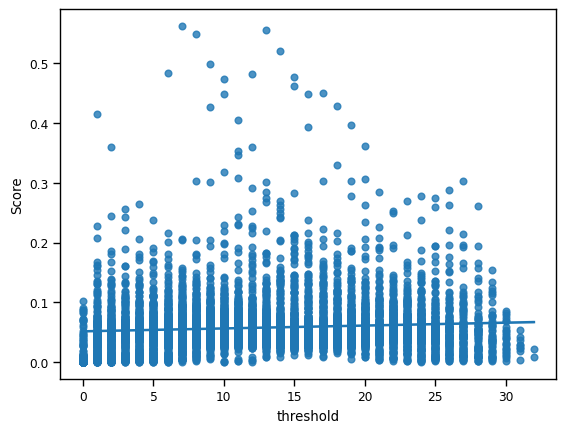

In [110]:
sns.regplot(scores.reset_index(), x="threshold", y="Score")

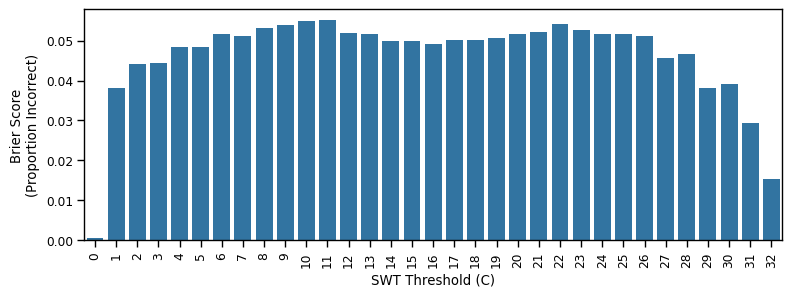

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
sns.barplot(scores.groupby("threshold").median(), x="threshold", y="Score", ax=ax)
ax.set_xlabel("SWT Threshold (C)")
ax.set_ylabel("Brier Score\n(Proportion Incorrect)")
_ = plt.xticks(rotation=90)

### Annual Threshold Skill

We're concerned with: annual max daily, 7-day, and 30-day mean. To work with the above Brier score code, all the column names need to stay the same.

In [136]:
dmax = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
dmax.describe()

count    209.000000
mean       0.073611
std        0.053951
min        0.000596
25%        0.019181
50%        0.070467
75%        0.119987
max        0.194375
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

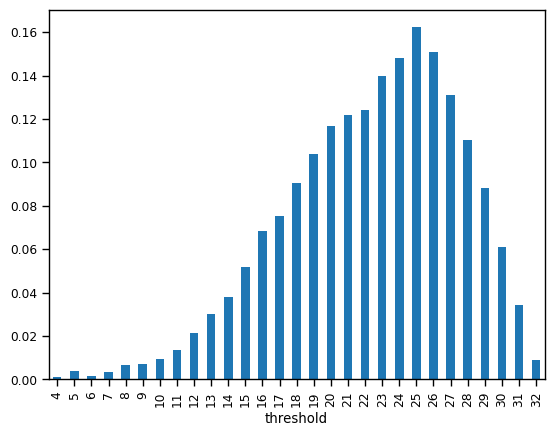

In [137]:
dmax.groupby("threshold").median().plot.bar()

In [138]:
d7max = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).rolling(7).mean().groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
d7max.describe()

count    213.000000
mean       0.063389
std        0.047258
min        0.000197
25%        0.015722
50%        0.061460
75%        0.104101
max        0.160264
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

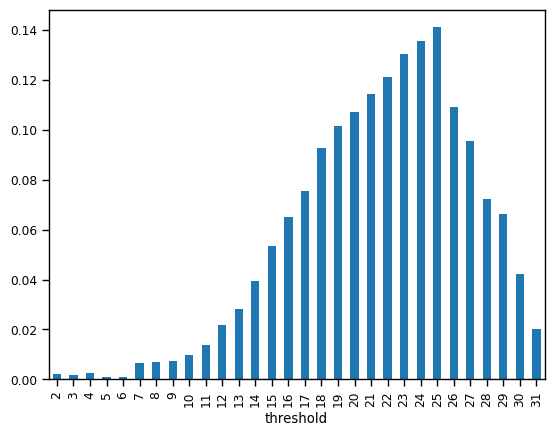

In [139]:
d7max.groupby("threshold").median().plot.bar()

In [140]:
d30max = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).rolling(30).mean().groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
d30max.describe()

count    203.000000
mean       0.058578
std        0.040872
min        0.000559
25%        0.017519
50%        0.059515
75%        0.093338
max        0.144758
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

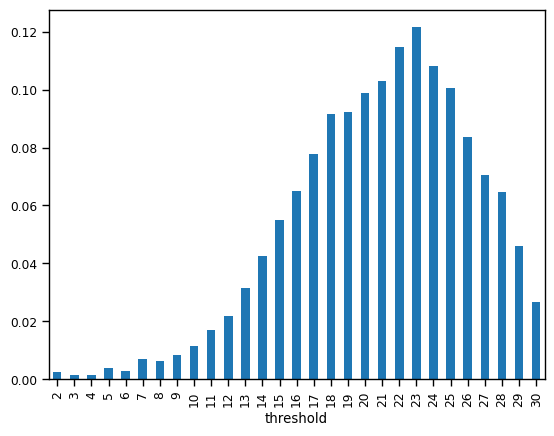

In [141]:
d30max.groupby("threshold").median().plot.bar()

### Regional Scoring

#### Worst Brier Score By Site

In [119]:
sites_worst = test_data.groupby("id")[["lat", "lon"]].agg("first").merge(scores.groupby("id")["Score"].max(), on="id")

In [130]:
sites_worst.describe()

,lat,lon,Score
count,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.117324
std,4.643460,17.260681,0.074081
min,28.332787,-124.357089,0.051194
25%,36.555978,-111.425710,0.075663
50%,40.175895,-87.479876,0.096304
75%,43.327292,-81.167361,0.130960
max,48.984601,-67.935278,0.562383


In [128]:
sites_worst.quantile([0.5, 0.75, 0.8, 0.85, 0.925, 0.95, 0.99])

,lat,lon,Score
0.500,40.175895,-87.479876,0.096304
0.750,43.327292,-81.167361,0.130960
0.800,44.071037,-79.914289,0.138654
0.850,44.943896,-77.674238,0.155340
0.925,46.417864,-75.089099,0.201522
0.950,47.436097,-73.978229,0.235347
0.990,48.702335,-71.470725,0.472186


In [120]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

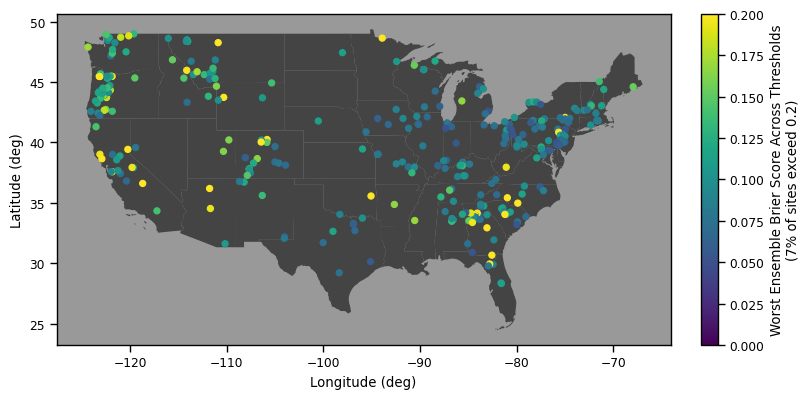

In [134]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#444")
sites_worst.plot.scatter(x="lon", y="lat", c="Score", ax=ax, colormap="viridis", vmin=0.0, vmax=0.2)
cb = ax.collections[1].colorbar
cb.set_label("Worst Ensemble Brier Score Across Thresholds\n(7% of sites exceed 0.2)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_brier.png", dpi=1000)

#### Annual Max Brier Scores By Region

In [146]:
dmax

,id,lat,lon,date,temperature,prediction_0.12_0,prediction_0.25_0,prediction_0.38_0,prediction_0.5_0,prediction_0.62_0,...,prediction_0.88_28,prediction_0.12_29,prediction_0.25_29,prediction_0.38_29,prediction_0.5_29,prediction_0.62_29,prediction_0.75_29,prediction_0.88_29,LatGroup,LonGroup
0,01022500,44.608056,-67.935278,2015,25.1,19.004933,19.007832,19.009970,19.011740,19.013510,...,17.432445,23.450580,23.453666,23.455941,23.457825,23.459708,23.461983,23.465069,8.0,-14.0
1,01022500,44.608056,-67.935278,2022,23.8,18.740736,18.743772,18.746009,18.747862,18.749715,...,17.205264,23.243208,23.246448,23.248837,23.250815,23.252792,23.255181,23.258421,8.0,-14.0
2,01054200,44.390556,-70.979722,2015,23.6,18.585823,18.588809,18.591011,18.592833,18.594656,...,11.313975,19.207538,19.210702,19.213034,19.214965,19.216896,19.219228,19.222391,8.0,-15.0
3,01054200,44.390556,-70.979722,2016,24.3,18.679140,18.682119,18.684316,18.686135,18.687954,...,11.376024,19.055040,19.057968,19.060128,19.061916,19.063703,19.065863,19.068792,8.0,-15.0
4,01054200,44.390556,-70.979722,2017,21.5,18.517373,18.520333,18.522515,18.524321,18.526128,...,11.269838,18.850435,18.853351,18.855501,18.857280,18.859060,18.861210,18.864126,8.0,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,394337079544201,39.727023,-79.911447,2019,28.3,26.617202,26.621053,26.623893,26.626244,26.628594,...,21.878972,26.393186,26.396937,26.399703,26.401992,26.404282,26.407048,26.410799,7.0,-16.0
2218,394337079544201,39.727023,-79.911447,2020,29.3,26.814946,26.818936,26.821877,26.824312,26.826747,...,22.067470,26.592504,26.596357,26.599198,26.601550,26.603901,26.606742,26.610595,7.0,-16.0
2219,452731123092100,45.458611,-123.155917,2020,17.5,12.930493,12.933119,12.935054,12.936657,12.938260,...,13.034487,17.948634,17.951301,17.953267,17.954895,17.956522,17.958488,17.961155,9.0,-25.0
2220,452731123092100,45.458611,-123.155917,2021,19.0,13.212658,13.215237,13.217138,13.218712,13.220285,...,13.353715,18.634710,18.637502,18.639560,18.641265,18.642969,18.645027,18.647820,9.0,-25.0


In [207]:
dmax = test_data.groupby("id")[["lat", "lon"]].agg("first").merge(
    values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).max(), on="id")
dmax["LatGroup"] = dmax["lat"] // 10
dmax["LonGroup"] = dmax["lon"] // 10
scores = pd.DataFrame(dmax.drop(columns=["lat", "lon"]).
                      groupby(["date", "LatGroup", "LonGroup"]).
                      apply(brier, include_groups=False).
                      groupby(["threshold", "LatGroup", "LonGroup"]).median().
                      groupby(["LatGroup", "LonGroup"]).max().rename("Score")
                     ).reset_index()
latlon = dmax.groupby(["LatGroup", "LonGroup"])[["lat", "lon"]].mean()
scores = scores.merge(latlon, on=["LatGroup", "LonGroup"])

In [208]:
scores.describe()

,LatGroup,LonGroup,Score,lat,lon
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,3.333333,-10.133333,0.237970,38.893255,-96.131896
std,0.723747,1.846490,0.088433,5.359656,17.465822
min,2.000000,-13.000000,0.004147,29.138022,-122.536141
25%,3.000000,-11.500000,0.222389,35.906629,-109.789883
50%,3.000000,-10.000000,0.251552,38.260158,-94.363719
75%,4.000000,-9.000000,0.299515,43.167518,-83.103110
max,4.000000,-7.000000,0.354386,46.244293,-67.935278


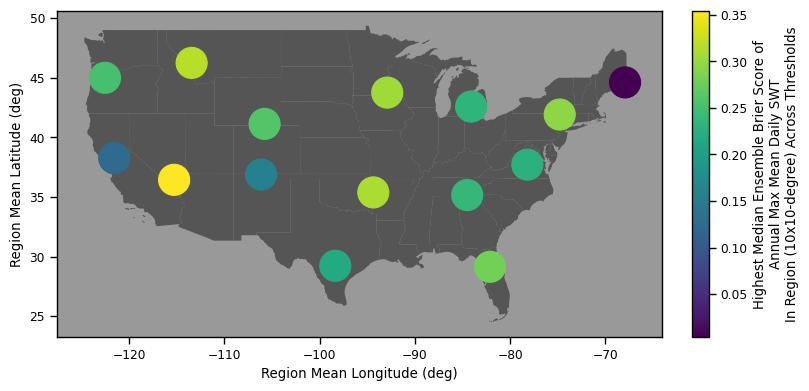

In [211]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#555")
scores.plot.scatter(x="lon", y="lat", c="Score", colormap="viridis", ax=ax, s=500)
cb = ax.collections[1].colorbar
cb.set_label("Highest Median Ensemble Brier Score of\nAnnual Max Mean Daily SWT\nIn Region (10x10-degree) Across Thresholds")
ax.set_xlabel("Region Mean Longitude (deg)")
ax.set_ylabel("Region Mean Latitude (deg)")
plt.savefig("val_figures/conus_regional_brier.png", dpi=1000)

### Interval Width

5-PC reference version with a noise factor of 0.9 and 240 ensemble members (30 x 8):

- 50% CI (3.3 C, IQR 2.7-3.9): almost perfect, median and mean are both 52%.
- 90% CI (8.0 C, IQR 7.0-9.1): about right, median capture is 91% and mean is 88%.
- 95% CI (10 C, IQR 8.7-12 C): about right, median capture is 97% and mean capture is 94%.

Translation: in general, we're more confident than not that the observation is within $\pm$1.7 C of the prediction, which is a useful range. We're very confident that it's within $\pm$5 C, but that's... a bit less useful.

In [222]:
size = 0.5
widths = values.loc[:, ["id", "date"]]
widths["upper"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1+size)/2), axis=1)
widths["lower"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1-size)/2), axis=1)
widths["median"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, 0.5), axis=1)
widths["width"] = widths["upper"] - widths["lower"]

In [ ]:
widths.describe()

,date,upper,lower,median,width
count,760075,760075.000000,760075.000000,760075.000000,760075.000000
mean,2019-03-08 00:47:17.846265344,15.125787,11.770061,13.410076,3.355726
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2017-04-21 00:00:00,9.383447,6.231195,7.793602,2.748585
50%,2019-04-06 00:00:00,14.850939,11.518742,13.177275,3.299951
75%,2021-02-14 00:00:00,20.768768,17.161408,18.982334,3.864248
max,2022-12-31 00:00:00,33.461943,30.133544,31.330121,21.150427
std,NaN,7.238853,6.956597,7.109802,1.005163


In [ ]:
widths["obs"] = values["temperature"]
widths["isin"] = (widths["obs"] <= widths["upper"]) & (widths["obs"] >= widths["lower"])

In [ ]:
widths.groupby("id")["isin"].mean().describe()

count    320.000000
mean       0.517719
std        0.144095
min        0.135135
25%        0.430563
50%        0.518466
75%        0.623064
max        0.866234
Name: isin, dtype: float64

In [ ]:
(widths.groupby("id")["isin"].mean() < size).mean()

0.446875

### Example Plots

In [227]:
which_sites = pd.Series(values["id"].unique()).sample(n=8)
sample = values.loc[values["id"].isin(which_sites)].melt(["id", "date", "temperature"])
sample

,id,date,temperature,variable,value
0,01022500,2015-01-01,0.0,prediction_0.12_0,1.145260
1,01022500,2015-01-02,0.0,prediction_0.12_0,1.088598
2,01022500,2015-01-03,0.0,prediction_0.12_0,1.034648
3,01022500,2015-01-04,0.0,prediction_0.12_0,0.983395
4,01022500,2015-01-05,0.0,prediction_0.12_0,0.934823
...,...,...,...,...,...
4028005,13056500,2016-12-26,0.0,prediction_0.88_29,0.917272
4028006,13056500,2016-12-27,0.0,prediction_0.88_29,0.833596
4028007,13056500,2016-12-28,0.0,prediction_0.88_29,0.765585
4028008,13056500,2016-12-29,0.0,prediction_0.88_29,0.719355


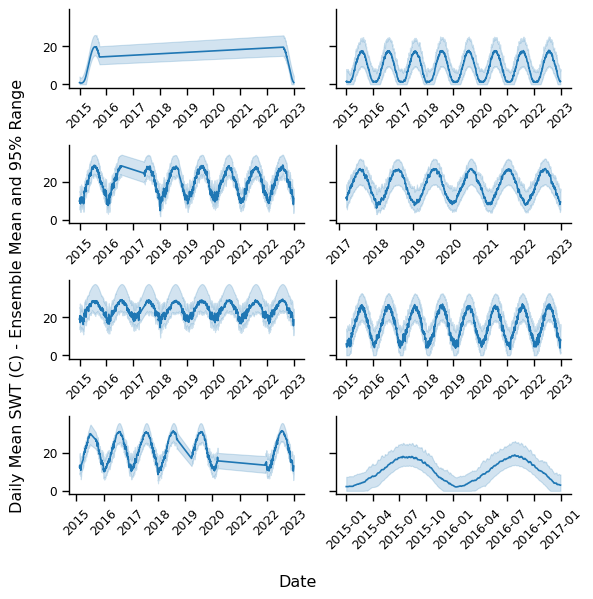

In [228]:
g = sns.relplot(sample,
            x="date",
            y="value",
            col="id",
            col_wrap=2,
            height=1.5,
            aspect=2,
            kind="line",
            facet_kws={"sharex": False},
            errorbar='pi').tick_params(axis='x', rotation=45)
g.set_axis_labels("", "")
g.set_titles("")
g.fig.supxlabel("Date")
g.fig.supylabel("Daily Mean SWT (C) - Ensemble Mean and 95% Range")
g.tight_layout()
g.savefig("val_figures/ensemble_plots.png", dpi=1200)

# Gagewise Cross-Validation

With no modification engines, runtime is 0.43 hours, making 1.7 seconds/site and >5 years/second.

With full-series runs and GAM-sensitivity, training still takes a few minutes, but prediction is almost instantaneous.  It still takes 0.4 hours total, suggesting that runtime is dominated by model training.

In [229]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            # return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [230]:
clim = False
lookback = 10
timing = bp + "results/kfold_times.txt"
out = bp + f"results/kfold_pca{coef_variant}.csv"
with warnings.catch_warnings(action="ignore"):
    start = time.time()
    kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=out, redo=rerun)
    print(f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Lookback: 10 :  0.45 hours for 928 sites with 2986986 observations


In [231]:
with warnings.catch_warnings(action="ignore"):
    perf = kfr.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,928.000000,928.000000,928.0,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,40.024700,-93.773787,0.0,0.901742,2.375107,0.422237,0.976426,0.914497,0.427790,3.739010,0.280904,2.717356
std,4.522685,17.162228,0.0,0.119177,1.150267,5.787243,0.017745,0.066951,0.266019,12.772010,1.486115,1.888503
min,26.975000,-124.392987,0.0,0.005163,1.069550,-168.320731,0.858323,0.175511,-3.995877,-69.073243,-19.605896,0.044581
25%,37.730899,-109.882554,0.0,0.897338,1.790100,0.791584,0.969363,0.900950,0.312085,-2.524254,-0.359398,1.274773
50%,40.132276,-86.485407,0.0,0.936090,2.108489,0.896974,0.980213,0.928521,0.480495,2.324453,0.291023,2.324376
75%,42.986410,-79.563692,0.0,0.955113,2.643941,0.933265,0.988360,0.949401,0.604884,7.974436,0.952941,3.698220
max,48.998814,-67.803889,0.0,0.981724,20.463058,0.979885,0.999005,0.988499,0.773595,110.673595,6.041176,18.616815


## Plots

In [232]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

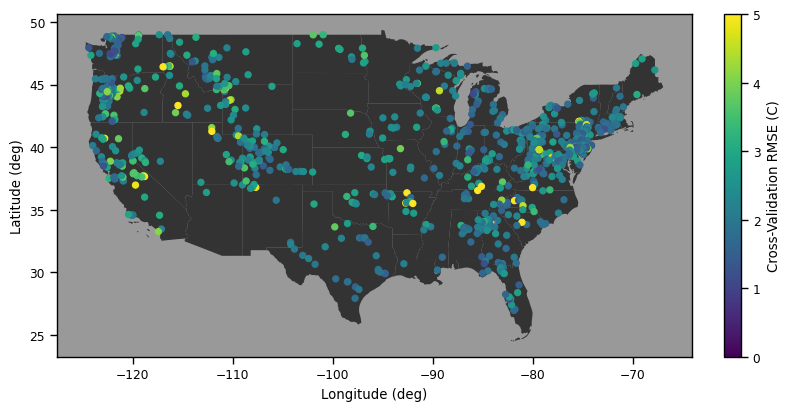

In [233]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="RMSE", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation RMSE (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_rmse.png", dpi=1000)

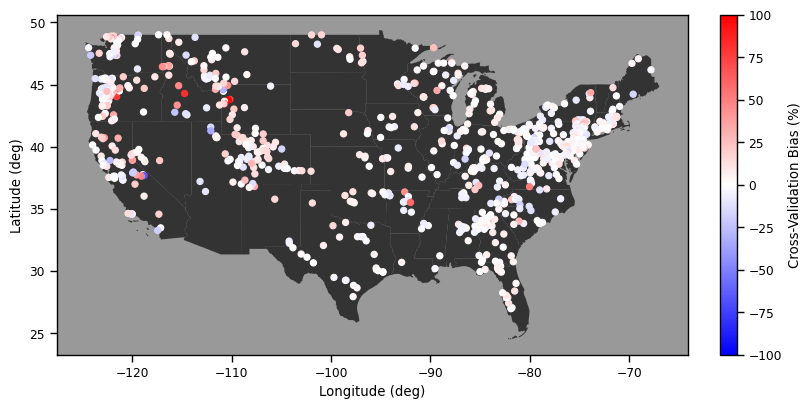

In [234]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="Pbias", ax=ax, colormap="bwr", vmin=-100, vmax=100)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation Bias (%)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_bias.png", dpi=1000)

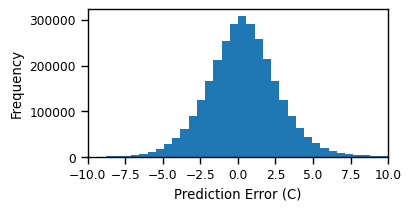

In [235]:
fig = plt.figure(figsize=(4, 2), layout="compressed")
ax = plt.axes()
kfr["error"] = kfr["prediction"] - kfr["temperature"]
kfr["error"].plot.hist(bins=100, ax=ax)
ax.set_xlim(-10, 10)
ax.set_xlabel("Prediction Error (C)")
plt.savefig("val_figures/ErrorHist_xv.png", dpi=1000)

In [236]:
ecos = gpd.read_file("ecoregions/NA_CEC_Eco_Level1.shp").to_crs(4326)

In [ ]:
def get_name(df):
    if len(df) > 0:
        return df.iloc[0]["NA_L1NAME"].title()
    else:
        return "NA"
perf_pts = gpd.GeoSeries([shapely.Point(x.lon, x.lat) for x in perf.itertuples()])
pt_ecos = pd.Series([get_name(ecos[ecos.contains(x)]) for x in perf_pts])

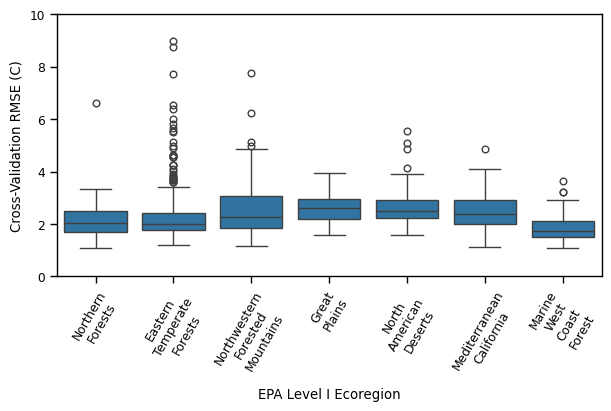

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="RMSE", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(0, 10)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation RMSE (C)")
plt.savefig("val_figures/EcoregionRMSEBox.png", dpi=1000)

In [ ]:
perf[perf["RMSE"] > 10]

,id,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss,ecoregion
562,06036940,44.732725,-110.713253,0,0.791194,15.201803,-11.587733,0.917760,0.824984,0.245907,-69.073243,-15.063868,16.016128,Northwestern\nForested\nMountains
730,10265150,37.668822,-118.817631,0,0.044793,20.463058,-17.518498,0.950897,0.175511,0.046946,-65.159327,-19.605896,18.616815,North\nAmerican\nDeserts


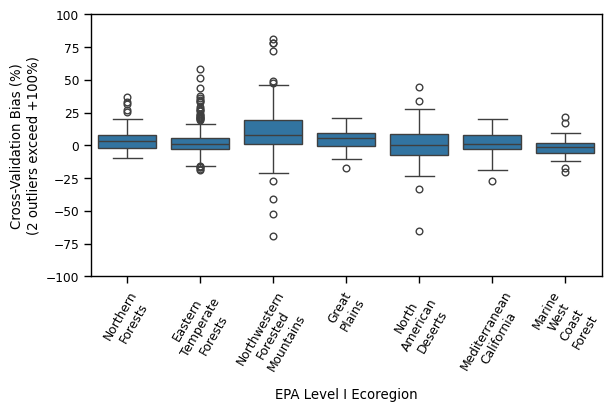

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="Pbias", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(-100, 100)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation Bias (%)\n(2 outliers exceed +100%)")
plt.savefig("val_figures/EcoregionBiasBox.png", dpi=1000)

# Extrapolation Tests

## Regional

For regional extrapolation, we split the CONUS into 16 grid cells (four-by-four), of which 15 actually contain gages and 14 have more than 1 gage.  Across those 14, we run a leave-one-out cross-validation, training a model on the other 13 and predicting all gages in the left-out grid cell.  This tests the ability of the model to make predictions for contiguous regions with no gages, meaning that it has no training data from nearby sites and has to go off its knowledge of general trends.

The cell 0x0 (southwesternmost) only has one gage in it, so results from that one should probably be ignored, but we'll include it.  The next fewest gages is 9, in Maine (3x3).  Some cells are, of course, considerably sparser than others, and gage count additionally varies with the size of cells on the US borders, as in the case of both 0x0 and 3x3.

In [ ]:
N = 4
latmin = all_data["lat"].min()
latmax = all_data["lat"].max() + 1
lonmin = all_data["lon"].min()
lonmax = all_data["lon"].max() + 1
latstep = (latmax - latmin)/N
lonstep = (lonmax - lonmin)/N

all_data["lat_cell"] = ((all_data["lat"] - latmin) / latstep).astype("int")
all_data["lon_cell"] = ((all_data["lon"] - lonmin) / lonstep).astype("int")
all_data["cell"] = all_data["lon_cell"].astype("str") + "x" + all_data["lat_cell"].astype("str")
sns.scatterplot(all_data.groupby("id")[["lat", "lon", "cell"]].first(), x="lon", y="lat", hue="cell")

In [ ]:
def modbuilder(data):
    nx = NEXT.NEXT.from_data(data)
    print("New region", end="")
    def prd(x):
        print("|", end="")
        try:
            return nx.run(x, reset=True)
        except KeyboardInterrupt as e:
            raise e
        except:
            return None
    return prd
with warnings.catch_warnings(action="ignore"):
    spatxv = NEWT.analysis.kfold(all_data, modbuilder, by='cell', k=1, output = bp + f"results/SpatialXV{coef_variant}.csv", redo=rerun)

In [ ]:
with warnings.catch_warnings(action="ignore"):
    spatperf = spatxv.groupby(["id", "cell"]).apply(NEWT.analysis.perf_summary)

In [ ]:
spatperf.describe()

In [ ]:
spatperf.groupby("cell")["RMSE"].median()

In [ ]:
ax = sns.boxplot(spatperf, x="cell", y="RMSE")
ax.set_xlabel("Spatial Cell")
ax.set_ylabel("Gage RMSE (C)\n(3 outliers exceed 10 C)")
ax.set_ylim(0, 10)

## Elevation

For elevation extrapolation, we train on the lower 95% and test on the upper 5%.  We also just plot errors by elevation.

### Non-Extrapolating

To look at bias, remove the `.abs()`.  There is no trend in bias and a modest trend in absolute error (about 2 -> 2.6 C in the combined cross-validation and test sets).  However, this seems to be because median errors are very high in the 2000-2500 m range; otherwise, there's no obvious trend.  With that group removed, the trend is present but weaker.

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "elev_min", "date", "prediction", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

In [ ]:
preds["error"] = (preds["prediction"] - preds["temperature"]).abs()
elev_perf = preds.groupby("id")[["elev_min", "error"]].mean()

In [ ]:
sns.lmplot(elev_perf, x="elev_min", y="error")

In [ ]:
elev_perf.assign(elev_bucket = lambda x: x["elev_min"] // 500).groupby("elev_bucket").median()

### Extrapolating

In [ ]:
all_data["elev_min"].quantile(0.95)

In [ ]:
train = all_data[all_data["elev_min"] < 1800]
test = all_data[all_data["elev_min"] >= 1800].dropna()

In [ ]:
len(test["id"].unique())

In [ ]:
def predict(model, ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except ValueError:
        return None

with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(train)
    prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index().drop(columns="level_1")

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = prd.groupby(["id", "lat", "lon", "elev_min"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index().drop(columns="level_4")
perf.describe()

In [ ]:
ax = sns.lmplot(perf, x="elev_min", y="RMSE")
ax.set_axis_labels("Pour Point Elevation (m)", "RMSE (C)")
ax.set(ylim=(0, 6))

In [ ]:
counts = prd.groupby("id", as_index=False)["date"].count()
eligible = perf[(perf["id"].isin(counts[(counts["date"] >= 365*3)]["id"])) &
               (perf["elev_min"] >= 2400)].sort_values("NSE")
best = eligible[eligible["RMSE"] < 4].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

In [ ]:
# Add non-extrapolating versions.
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = prd[prd["id"] == which].sort_values("date")
        site_nx = preds[preds["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nNSE={round(prow['NSE'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["prediction"], label="TempEst-NEXT\n(Extrapolating)")
        ax.plot(site_nx["date"], site_nx["prediction"], label="TempEst-NEXT\n(Non-Extrapolating)")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")

In [ ]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False)
ssn_mod = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["prediction"]), include_groups=False)

In [ ]:
ssn_obs.describe()

In [ ]:
ssn_mod.describe()

## Walk-Forward

For walk-forward validation, we train a model on all sites up to a given year, then predict the next five year.  This is done for all prediction years from 2010-2022, allowing ten years of initial training data.  We predict five years at a time to provide sufficient coefficient estimation data, since it's running in ungaged mode.

In [ ]:
all_data["year"] = all_data["date"].dt.year
years = list(range(2010, 2023, 5))
file = bp + f"results/WalkForward{coef_variant}.csv"
def runmod(mod, data):
    # Try/catch because some single-year snapshots don't have enough data.
    # This shouldn't happen for prediction use, but as implemented for testing,
    # missing ST obs = missing data, since the rows get dropped.
    try:
        return mod.run(data, reset=True, use_climate=False)
    except:
        return None
def runner(year):
    print(year)
    model = NEXT.NEXT.from_data(all_data[all_data["year"] < year])
    inp = all_data[(all_data["year"] >= year) & (all_data["year"] < year + 5)]
    return inp.groupby("id").apply(lambda x: runmod(model, x), include_groups=False)
if not rerun and os.path.exists(file):
    wfv = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
    wfv["id"] = wfv.index
else:
    with warnings.catch_warnings(action="ignore"):
        wfv = pd.concat([runner(year) for year in years])
    wfv.to_csv(file, index_label="id")

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = wfv.groupby("id").apply(NEWT.analysis.perf_summary)

In [ ]:
perf.describe()

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf_byyr = wfv.groupby(["id", "year"]).apply(NEWT.analysis.perf_summary).groupby("year").median()

The first prediction years are 2010, 2015, and 2020.  These aren't distinctly low-error years, nor are the last (2014, 2019, 2022) consistently high-error.  So it doesn't seem to have any problem with extrapolating forward, in terms of RMSE.  We also don't see a trend in bias.

In [ ]:
ax = sns.lineplot(perf_byyr, x=perf_byyr.index, y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

In [ ]:
perf_byyr["pyr"] = list(range(1, 6))*2 + [1,2,3]
ax = sns.regplot(perf_byyr, x="pyr", y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

In [ ]:
scipy.stats.pearsonr(perf_byyr["pyr"], perf_byyr["RMSE"])

## Hot/Wet/Dry

In [ ]:
def predict(model, ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except ValueError:
        return None

def runit(data, variable, gt):
    # gt: greater than? (Bool) or less than
    with warnings.catch_warnings(action="ignore"):
        stats = data.groupby("id", as_index=False)[variable].mean()
        threshold = stats[variable].quantile(0.95) if gt else stats[variable].quantile(0.05)
        print(threshold)
        train_id = (stats.loc[stats[variable] <= threshold] if gt else stats.loc[stats[variable] > threshold])["id"]
        test_id = stats.loc[-stats["id"].isin(train_id)]["id"]
        train = data.loc[data["id"].isin(train_id)]
        test = data.loc[data["id"].isin(test_id)]
        model = NEXT.NEXT.from_data(train)
        prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index()
        return prd.groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "tmax", "prcp", "date", "prediction", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

### Hot

In [ ]:
sel = preds.groupby("id").apply(lambda y: y.assign(test=lambda x: x["tmax"] > x["tmax"].quantile(0.95)), include_groups=False)
with warnings.catch_warnings(action="ignore"):
    perf = sel.loc[sel["test"]].groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)
perf.describe()

In [ ]:
perf = runit(all_data, "tmax", True)
perf.describe()

### Wet

In [ ]:
sel = preds.groupby("id").apply(lambda y: y.assign(test=lambda x: x["prcp"] > x["prcp"].quantile(0.95)), include_groups=False)
with warnings.catch_warnings(action="ignore"):
    perf = sel.loc[sel["test"]].groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)
perf.describe()

In [ ]:
perf = runit(all_data, "prcp", True)
perf.describe()

### Dry

In [ ]:
sel = preds.groupby("id").apply(lambda y: y.assign(test=lambda x: x["prcp"] == 0), include_groups=False)
with warnings.catch_warnings(action="ignore"):
    perf = sel.loc[sel["test"]].groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)
perf.describe()

In [ ]:
perf = runit(all_data, "prcp", False)
perf.describe()

## Regime Shift/Disturbance

# Small Stream

# True Forecast

For forecast testing, we run a 16-day forecast using HRRR and GFS (HRRR for day 1-2, GFS after that).  We also use HRRR to fill in "last week" for anomaly smoothing.  Then, we come back in a few weeks and check the performance.  Performance testing should use RMSE and bias only, since trend metrics (R2, NSE) will have minimal observed variance to work with.  Performance should be analyzed aggregated by lead time.  For the 2-day lead (tomorrow's mean), we should expect the RMSE to converge on about 2.4 C.

Since this is an ungaged model, and the only ungaged forecasting model, there is no reference performance to use for computing a skill score.  Instead, the question is whether the error is sufficiently low as to be useful.

## Shape Retrieval

As of this writing, the NLDI service is down, so we're going to use cached shapefiles.  This is (hopefully) temporary and should be changed to use regular retrieval functions.

## Run Forecast

## Verify Forecasts

In [ ]:
fcp = bp + "forecasts/"
def parse_fc(fn):
    rundate = np.datetime64(fn.split(".")[0])
    fcdat = pd.read_csv(fcp + fn, parse_dates=["date"], dtype={"id": "str"})
    fcdat = fcdat.loc[fcdat["date"] >= rundate, :]
    fcdat["rundate"] = rundate
    fcdat["lead"] = ((fcdat["date"] - rundate + np.timedelta64(1, 'D'))/np.timedelta64(1, 'D')).astype(int)  # +1: today's mean is a 1-day lead.
    return fcdat
forecast = pd.concat([parse_fc(fn) for fn in os.listdir(fcp)])
forecast = forecast.loc[forecast["lead"] < 17]  # 17-day shouldn't be in there

In [ ]:
sites = list(forecast["id"].unique())
# Run from first forecast date.
obs = nwis.get_dv(sites=sites, start="2025-02-07", end="2030-01-01", parameterCd="00010")[
    0].reset_index()[["site_no", "datetime", "00010_Mean"]].rename(
        columns={"00010_Mean": "temperature", "site_no": "id", "datetime": "date"}
    ).dropna().assign(date=lambda x: x["date"].dt.normalize().dt.tz_localize(None))
obs = obs[obs["temperature"] > -1]

In [ ]:
merged = forecast.merge(obs, on=["id", "date"], how="left").dropna()
with warnings.catch_warnings(action="ignore"):
    perf = merged.groupby(["id", "lead"]).apply(NEWT.analysis.perf_summary, include_groups=False)
perf[["RMSE", "Bias"]].describe()

In [ ]:
meds = perf.groupby("lead")[["RMSE", "Bias"]].median()
meds

In [ ]:
bylead = merged.groupby("lead").apply(NEWT.analysis.perf_summary, include_groups=False)
bylead

In [ ]:
round(meds.reset_index().merge(bylead, on="lead", suffixes=["_median", "_global"])[["lead", "RMSE_median", "RMSE_global", "Bias_median", "Bias_global"]
                                                                                  ].rename(
    columns={"lead": "Lead Time (days)",
             "RMSE_median": "Median RMSE (C)",
             "RMSE_global": "Global RMSE (C)",
             "Bias_median": "Median Bias (C)",
             "Bias_global": "Global Bias (C)"}), 1)

In [ ]:
NEWT.analysis.perf_summary(merged)

In [ ]:
# ax = merged.plot.scatter(x="prediction", y="temperature")
pmerged = merged.merge(bylead.round(2), on="lead", how="left")
minmax = [merged["temperature"].min(), merged["temperature"].max()]
minmax = pd.DataFrame({"x": minmax, "y": minmax})
# pmerged["lead"] = pmerged["lead"].astype(str) + " (RMSE: " + pmerged["RMSE"].astype(str) + " C)"
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="compressed")
# sns.scatterplot(pmerged, x="temperature", y="prediction", hue="lead", ax=ax)
fig = sns.relplot(pmerged, x="temperature", y="prediction", col="lead", col_wrap=4,
                   height=2, aspect=1, kind="scatter")
for ax in fig.axes:
    sns.lineplot(minmax, x="x", y="y", ax=ax)
fig.figure.supxlabel("Observed Temperature (C)")
fig.set_xlabels("")
fig.figure.supylabel("Modeled Temperature (C)")
fig.set_ylabels("")
fig.set_titles(col_template="Lead Time: {col_name} days")
# ax.plot(pmerged["temperature"], pmerged["temperature"], label="1:1")
# ax.set_ylabel("Modeled Temperature (C)")
# ax.set_xlabel("Observed Temperature (C)")
# ax.legend().set_title("Lead Time (days)")
plt.savefig("val_figures/forecast.png", dpi=1000)

## National Plots

In [ ]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

In [ ]:
coords = test_data_hrrr.groupby("id")[["lat", "lon"]].agg("first")
bestworst = (perf.groupby("id").
             apply(lambda x: pd.DataFrame({"best": x["RMSE"].min(), "worst": x["RMSE"].max()}, index=[0]),
                   include_groups=False).
             merge(coords, on="id", how="left"))

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="best", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Lowest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_best.png", dpi=1000)

In [ ]:
bestworst.describe()

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="worst", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Highest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_worst.png", dpi=1000)

# Error Correlations

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
gcols = ["id", "elev_min", "elev", "lat", "lon", "area", 'water', 'developed', 'barren', 'forest', 'shrubland', 'herbaceous',
       'cultivated', 'wetland', 'ice_snow', "slope", "flowdir"]
ycols = ["date", "prediction", "temperature"]
cols = gcols + ycols
preds = pd.concat([preds[cols], kfr[cols]])

In [ ]:
x = np.arange(10)
y = np.arange(10, 0, -1)
x[x<y] = y[x<y]
x

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(gcols).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()

In [ ]:
hap = perf[perf["area"] > 3e10]

In [ ]:
sel = perf#[perf["area"] > 3e10]
ax = sns.regplot(sel, x="area", y="RMSE")
# ax.set_xlim(4e10, 10e10)
# ax.set_ylim(0, 1)

In [ ]:
scipy.stats.pearsonr(sel["area"], sel["Pbias"])

In [ ]:
perf[gcols[1:]].agg(lambda x: scipy.stats.pearsonr(x, perf["NSE"]).statistic).abs().sort_values(ascending=False)

# Misc Plots

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
# kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "date", "prediction", "temperature"]
# preds = pd.concat([preds[cols], kfr[cols]])
# preds = pd.read_csv(bp + "TE2Xval.csv", dtype={"id": "str"}, parse_dates=["date"])[cols]
# preds = preds.loc[preds["temperature"] < 35, :]  # for direct comparison to USGS dataset
perf = preds.groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)

## 1:1 Plot with Stats

## Sitewise R2 CDF

## Temperature Density

## Sim/Obs Sample

In [ ]:
counts = preds.groupby("id", as_index=False)["date"].count()
eligible = perf.reset_index()[perf.unstack().index.isin(counts[(counts["date"] >= 365*3)]["id"])].sort_values("R2")
best = eligible[eligible["RMSE"] < 1.8].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

In [ ]:
eligible.iloc[0].to_dict()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = preds[preds["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nR2={round(prow['R2'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["prediction"], label="TempEst-NEXT")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")
plt.savefig("val_figures/comparison_sample.png", dpi=1000)